In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Define paths for train and test folders
train_path = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set/"
test_path = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/"

# List the contents of the Train and Test directories
print("Train Classes:", os.listdir(train_path))
print("Test Classes:", os.listdir(test_path))

Train Classes: ['FU-nail-fungus', 'FU-ringworm', 'VI-shingles', 'BA-impetigo', 'FU-athlete-foot', 'VI-chickenpox', 'PA-cutaneous-larva-migrans', 'BA- cellulitis']
Test Classes: ['FU-nail-fungus', 'FU-ringworm', 'VI-shingles', 'BA-impetigo', 'FU-athlete-foot', 'VI-chickenpox', 'PA-cutaneous-larva-migrans', 'BA- cellulitis']


In [18]:
def createDF(folderpath):
    data = []
    
    for category in os.listdir(folderpath):
        category_path = os.path.join(folderpath, category)
        
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)
                
                data.append({"image_path": image_path, "category": category})
    
    df = pd.DataFrame(data)

    return df

train_df = createDF(train_path)
test_df = createDF(test_path)

In [19]:
train_df.head()

,image_path,category
0,/kaggle/input/skin-disease-dataset/skin-diseas...,FU-nail-fungus
1,/kaggle/input/skin-disease-dataset/skin-diseas...,FU-nail-fungus
2,/kaggle/input/skin-disease-dataset/skin-diseas...,FU-nail-fungus
3,/kaggle/input/skin-disease-dataset/skin-diseas...,FU-nail-fungus
4,/kaggle/input/skin-disease-dataset/skin-diseas...,FU-nail-fungus


category
BA- cellulitis                136
VI-chickenpox                 136
VI-shingles                   130
FU-nail-fungus                129
FU-athlete-foot               124
PA-cutaneous-larva-migrans    100
FU-ringworm                    90
BA-impetigo                    80
Name: count, dtype: int64


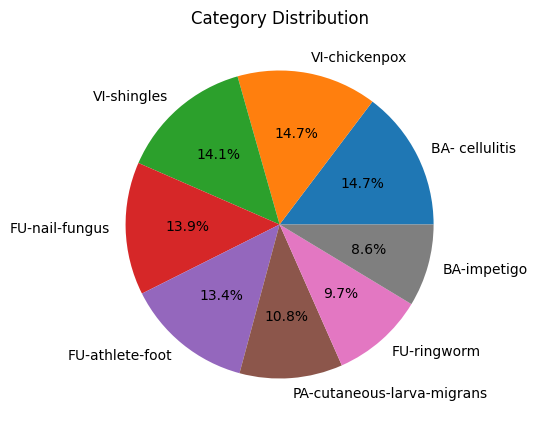

category
BA- cellulitis                34
VI-chickenpox                 34
FU-nail-fungus                33
VI-shingles                   33
FU-athlete-foot               32
PA-cutaneous-larva-migrans    25
FU-ringworm                   23
BA-impetigo                   20
Name: count, dtype: int64


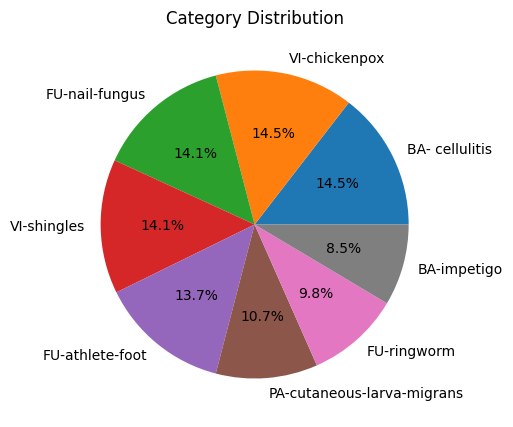

In [20]:
def show_df_distribution(df):
    category_counts = df["category"].value_counts()
    print(category_counts)
    
    plt.figure(figsize=(12, 5))
    plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
    plt.title("Category Distribution")
    plt.show()

show_df_distribution(train_df)
show_df_distribution(test_df)

In [21]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, shuffle=True)

In [22]:
class_names = sorted(train_df['category'].unique())

def apply_one_hot_encoding(df):
    class_names = sorted(df['category'].unique())
    df_encoded = pd.get_dummies(df['category'], dtype=int)
    df_final = pd.concat([df, df_encoded], axis=1)
    df_final = df_final.drop(columns=['category'])

    return df_final

train_df = apply_one_hot_encoding(train_df)
val_df = apply_one_hot_encoding(val_df)
test_df = apply_one_hot_encoding(test_df)

In [23]:
train_df.head()

,image_path,BA- cellulitis,BA-impetigo,FU-athlete-foot,FU-nail-fungus,FU-ringworm,PA-cutaneous-larva-migrans,VI-chickenpox,VI-shingles
882,/kaggle/input/skin-disease-dataset/skin-diseas...,1,0,0,0,0,0,0,0
96,/kaggle/input/skin-disease-dataset/skin-diseas...,0,0,0,1,0,0,0,0
371,/kaggle/input/skin-disease-dataset/skin-diseas...,0,1,0,0,0,0,0,0
66,/kaggle/input/skin-disease-dataset/skin-diseas...,0,0,0,1,0,0,0,0
342,/kaggle/input/skin-disease-dataset/skin-diseas...,0,0,0,0,0,0,0,1


In [24]:
OVERSAMPLING_FACTOR = 4.0 
non_class_columns = ['image_path'] 
target_classes = [col for col in train_df.columns if col not in non_class_columns]

print(f"Detected Classes: {target_classes}")

data_frames_to_concat = [train_df]

for class_name in target_classes:
    if class_name in train_df.columns:
        class_rows = train_df[train_df[class_name] == 1]
        if len(class_rows) == 0:
            continue

        print(f"Processing {class_name}: Adding {OVERSAMPLING_FACTOR}x amount...")
        oversampled_rows = class_rows.sample(frac=OVERSAMPLING_FACTOR, replace=True, random_state=42)
        
        data_frames_to_concat.append(oversampled_rows)

train_df_balanced = pd.concat(data_frames_to_concat, ignore_index=True)
train_df_balanced = train_df_balanced.sample(frac=1).reset_index(drop=True)

print("\n--- Before vs After Counts ---")
for col in target_classes:
    old_count = train_df[col].sum()
    new_count = train_df_balanced[col].sum()
    print(f"{col}: {old_count} -> {new_count}")

Detected Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']
Processing BA- cellulitis: Adding 4.0x amount...
Processing BA-impetigo: Adding 4.0x amount...
Processing FU-athlete-foot: Adding 4.0x amount...
Processing FU-nail-fungus: Adding 4.0x amount...
Processing FU-ringworm: Adding 4.0x amount...
Processing PA-cutaneous-larva-migrans: Adding 4.0x amount...
Processing VI-chickenpox: Adding 4.0x amount...
Processing VI-shingles: Adding 4.0x amount...

--- Before vs After Counts ---
BA- cellulitis: 123 -> 615
BA-impetigo: 74 -> 370
FU-athlete-foot: 110 -> 550
FU-nail-fungus: 116 -> 580
FU-ringworm: 80 -> 400
PA-cutaneous-larva-migrans: 93 -> 465
VI-chickenpox: 121 -> 605
VI-shingles: 115 -> 575


In [25]:
rotation_layer = tf.keras.layers.RandomRotation(factor=1) 
translation_layer = tf.keras.layers.RandomTranslation(height_factor=0.3, width_factor=0.3, fill_mode='nearest')
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.3, width_factor=0.3)

def load_image(path, label):
    def _load_with_pil(image_path):
        image_path = image_path.numpy()
        img = Image.open(image_path).convert('RGB')
        return np.array(img)
    image = tf.py_function(func=_load_with_pil, inp=[path], Tout=tf.uint8)

    image.set_shape([None, None, 3])

    image = tf.image.resize(image, [299, 299])
    
    return image, label
    
def augment_image(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3 * 255)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    
    image = tf.expand_dims(image, 0) 
    image = rotation_layer(image) 
    image = translation_layer(image)
    image = zoom_layer(image)
    image = image[0]
    
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.03 * 255, dtype=tf.float32)
    image = tf.add(image, noise)

    image = tf.clip_by_value(image, 0, 255)
    
    return image, label
    
def apply_inception_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

In [26]:
def create_dataset(dataframe, batch_size=8, is_training=False):
    AUTOTUNE = tf.data.AUTOTUNE
    
    paths = dataframe['image_path'].values
    labels = dataframe[class_names].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    
    ds = ds.map(apply_inception_preprocess, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=1000)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [27]:
BATCH_SIZE = 8

print("Creating Training Dataset...")
train_ds = create_dataset(train_df_balanced, batch_size=BATCH_SIZE, is_training=True)

print("Creating Validation Dataset...")
val_ds = create_dataset(val_df, batch_size=BATCH_SIZE, is_training=False)

print("Creating Test Dataset...")
test_ds = create_dataset(test_df, batch_size=BATCH_SIZE, is_training=False)

print("✅ All Datasets are ready.")

Creating Training Dataset...
Creating Validation Dataset...
Creating Test Dataset...
✅ All Datasets are ready.


In [28]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False 

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.4)(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)

predictions = Dense(8, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 108s 140ms/step - accuracy: 0.2483 - loss: 1.9690 - val_accuracy: 0.7312 - val_loss: 1.2564
Epoch 2/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.5006 - loss: 1.4059 - val_accuracy: 0.7849 - val_loss: 0.8493
Epoch 3/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.6018 - loss: 1.1451 - val_accuracy: 0.7849 - val_loss: 0.7282
Epoch 4/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.6623 - loss: 0.9962 - val_accuracy: 0.8602 - val_loss: 0.5775
Epoch 5/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.6877 - loss: 0.9000 - val_accuracy: 0.8817 - val_loss: 0.5060
Epoch 6/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7269 - loss: 0.8205 - val_accuracy: 0.8817 - val_loss: 0.4546
Epoch 7/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7333 - loss: 0.7821 - val_accuracy: 0.8817 - val_loss: 0.4200
Epoch 8/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7600 

In [31]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

Building ResNet50V2...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training ResNet50V2...
Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - accuracy: 0.3758 - loss: 1.7157 - val_accuracy: 0.8065 - val_loss: 0.7180
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accuracy: 0.6643 - loss: 0.9440 - val_accuracy: 0.8710 - val_loss: 0.4999
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.7643 - loss: 0.7111 - val_accuracy: 0.9032 - val_loss: 0.3894
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.8008 - loss: 0.5963 - val_accuracy: 0.9032 - val_loss: 0.3530
Epoch 5/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.8327 - loss: 0.5305 - val_accuracy: 0.9355 - val_loss: 0.2975
Epoch 6/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.8414 - loss: 0.4532 - val_accuracy: 0.9247 - val_loss: 0.2911
Epoch 7/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.8577 - loss: 0.4298 - val_accuracy: 0.9247 - val_loss: 

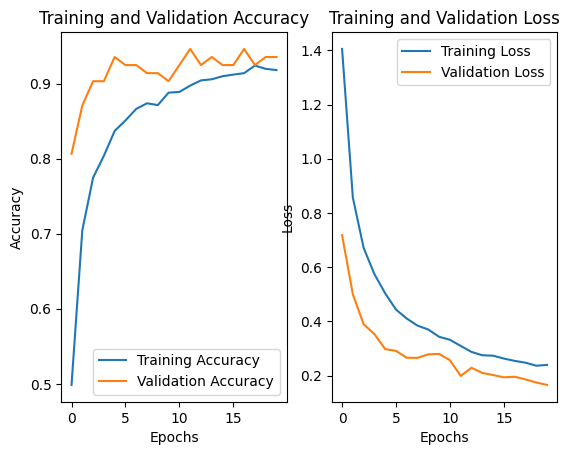

In [32]:

# MODEL 2: ResNet50V2 (For Comparison)

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model.trainable = False 

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) 
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Combine and Compile
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

print("Building ResNet50V2...")
resnet_model = build_resnet_model(input_shape=(224, 224, 3), num_classes=8)

print("Training ResNet50V2...")
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, 
    verbose=1,
    callbacks=[early_stopping]
    
)

print("--- Performance of ResNet50V2 ---")
plot_training_history(history_resnet)

Generating Architecture Diagrams...
✅ Diagrams saved.

 EVALUATING: InceptionResNetV2
⏳ Generating predictions...
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step


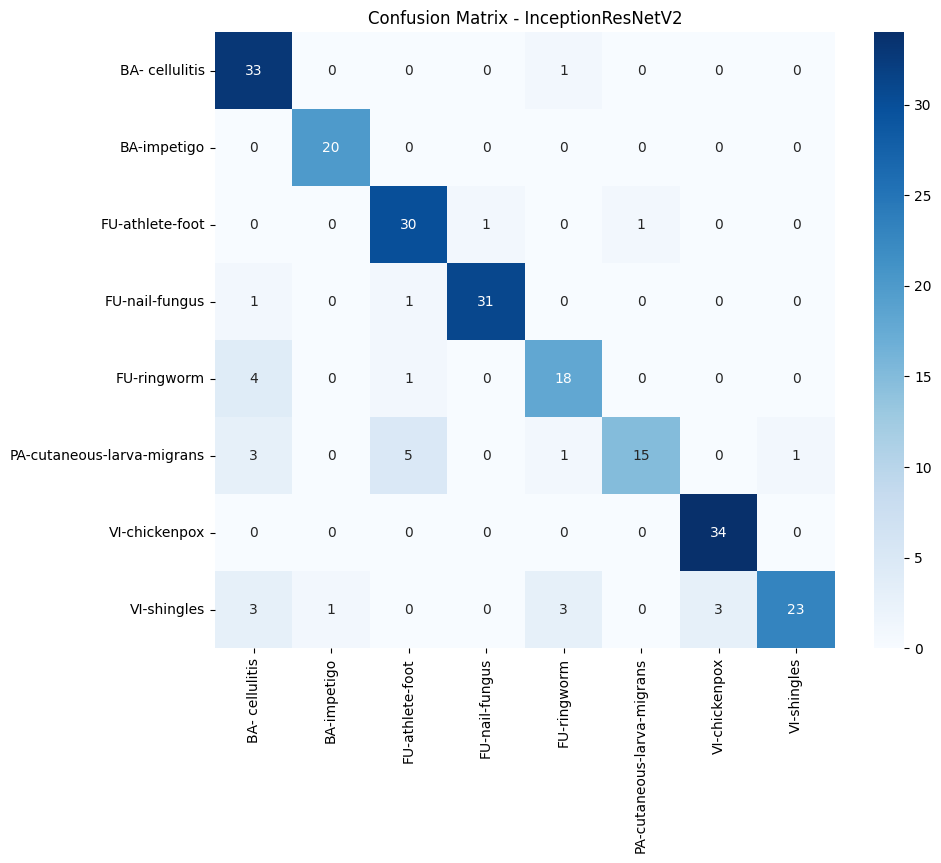

Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.75      0.97      0.85        34
               BA-impetigo       0.95      1.00      0.98        20
           FU-athlete-foot       0.81      0.94      0.87        32
            FU-nail-fungus       0.97      0.94      0.95        33
               FU-ringworm       0.78      0.78      0.78        23
PA-cutaneous-larva-migrans       0.94      0.60      0.73        25
             VI-chickenpox       0.92      1.00      0.96        34
               VI-shingles       0.96      0.70      0.81        33

                  accuracy                           0.87       234
                 macro avg       0.88      0.87      0.87       234
              weighted avg       0.88      0.87      0.87       234



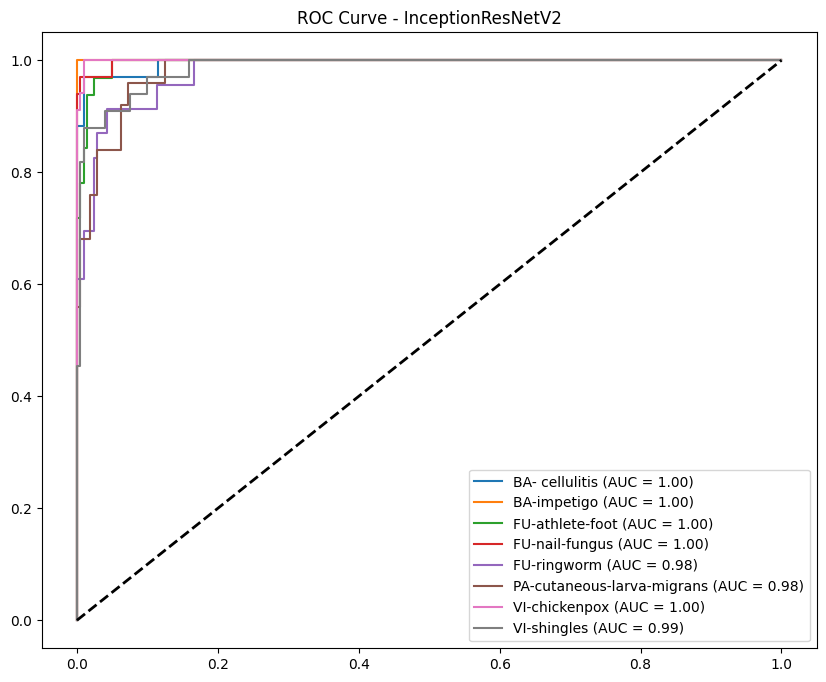


 EVALUATING: ResNet50V2
⏳ Generating predictions...
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step


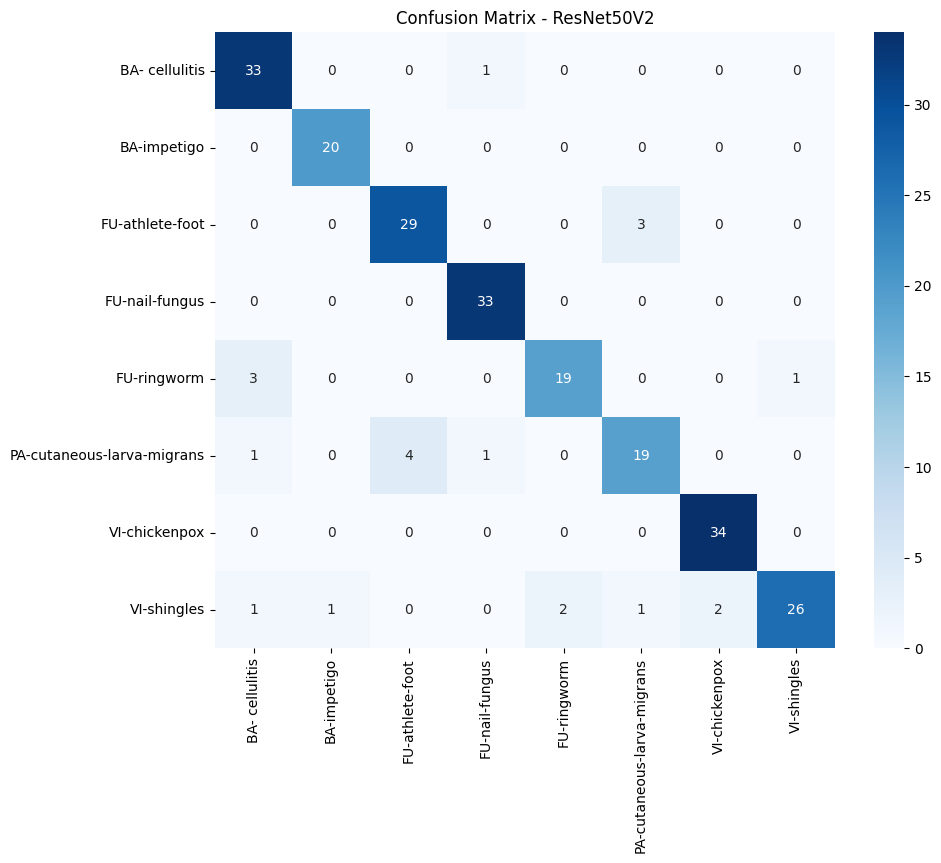

Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.87      0.97      0.92        34
               BA-impetigo       0.95      1.00      0.98        20
           FU-athlete-foot       0.88      0.91      0.89        32
            FU-nail-fungus       0.94      1.00      0.97        33
               FU-ringworm       0.90      0.83      0.86        23
PA-cutaneous-larva-migrans       0.83      0.76      0.79        25
             VI-chickenpox       0.94      1.00      0.97        34
               VI-shingles       0.96      0.79      0.87        33

                  accuracy                           0.91       234
                 macro avg       0.91      0.91      0.91       234
              weighted avg       0.91      0.91      0.91       234



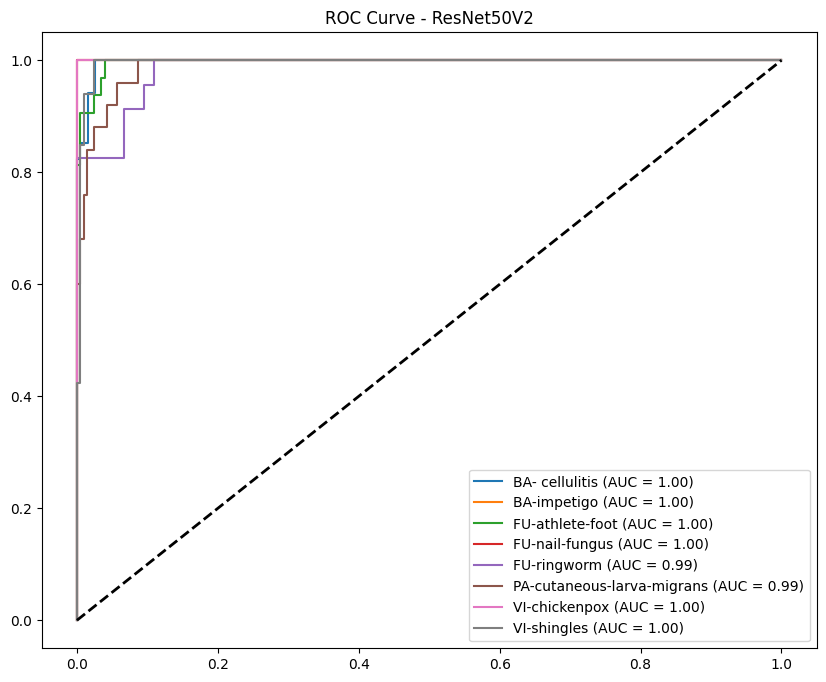


=== FINAL COMPARATIVE ANALYSIS ===
               Model  Accuracy  F1-Score
0  InceptionResNetV2  0.871795  0.865532
1         ResNet50V2  0.910256  0.906071


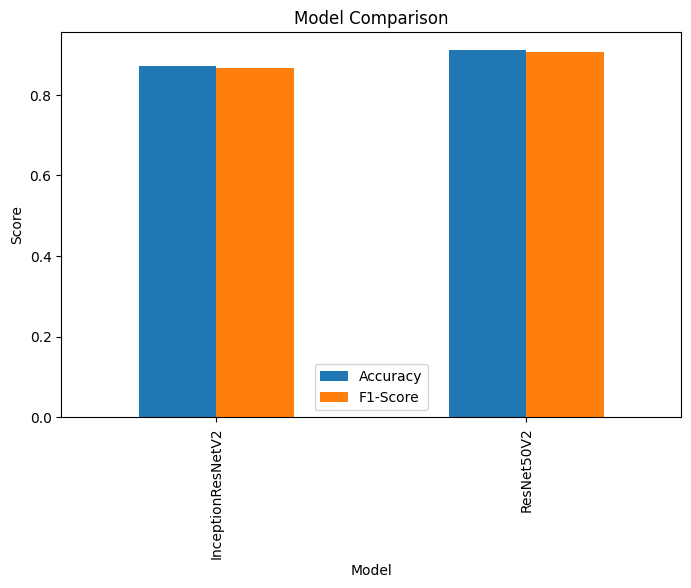

✅ Saved ResNet50V2 (Acc: 91.03%)


In [33]:

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import plot_model

print("Generating Architecture Diagrams...")
try:
    plot_model(model, to_file='inception_architecture.png', show_shapes=True, show_layer_names=True)
    plot_model(resnet_model, to_file='resnet_architecture.png', show_shapes=True, show_layer_names=True)
    print("✅ Diagrams saved.")
except:
    print("⚠️ Could not save diagrams (requires pydot). Skipping.")

def evaluate_full_report(model, test_ds, test_df, model_name):
    print(f"\n{'='*20}\n EVALUATING: {model_name}\n{'='*20}")
    
    print("⏳ Generating predictions...")
    y_pred_probs = model.predict(test_ds, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_df[class_names].values, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    print("Classification Report:")
    report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    #  ROC Curve
    fpr, tpr, roc_auc = dict(), dict(), dict()
    n_classes = len(class_names)
    y_true_onehot = test_df[class_names].values

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return report_dict['accuracy'], report_dict['macro avg']['f1-score']


acc_inception, f1_inception = evaluate_full_report(model, test_ds, test_df, "InceptionResNetV2")
acc_resnet, f1_resnet = evaluate_full_report(resnet_model, test_ds, test_df, "ResNet50V2")

#Final Comparison Table
comparison_df = pd.DataFrame({
    'Model': ['InceptionResNetV2', 'ResNet50V2'],
    'Accuracy': [acc_inception, acc_resnet],
    'F1-Score': [f1_inception, f1_resnet]
})

print("\n=== FINAL COMPARATIVE ANALYSIS ===")
print(comparison_df)

comparison_df.plot(x='Model', kind='bar', figsize=(8, 5), title="Model Comparison")
plt.ylabel("Score")
plt.show()

# the Winner
if acc_inception > acc_resnet:
    model.save('best_skin_model.h5')
    print(f"✅ Saved InceptionResNetV2 (Acc: {acc_inception:.2%})")
else:
    resnet_model.save('best_skin_model.h5')
    print(f"✅ Saved ResNet50V2 (Acc: {acc_resnet:.2%})")

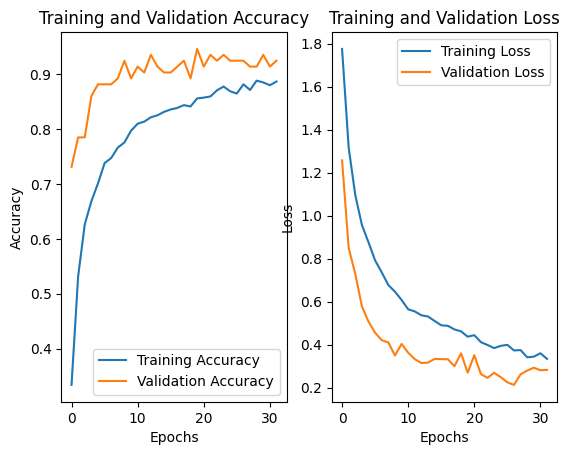

In [34]:
plot_training_history(history)